In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
#tf.compat.v1.disable_eager_execution()

import matplotlib.pyplot as plt
import numpy as np
import time
import gym
from gym import wrappers

In [26]:
class ReplayBuffer():
    def __init__(self, max_size, n_states):
        self.mem_size = max_size # replay buffer size, max number of experiences to store
        self.mem_cntr = 0  # replay buffer counter (used for indexing later)
        self.state_memory = np.zeros((self.mem_size, n_states), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, n_states), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.int32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size # When memory counter goes past max replay size, 
                                              # indexes at start of array
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size) # number of experiences in replay buffer
        batch = np.random.choice(max_mem, batch_size, replace=False) # select # experiences to 
                                                                     # train on
        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        rewards = self.reward_memory[batch]
        actions = self.action_memory[batch]
        terminal = self.terminal_memory[batch]
        return states, actions, rewards, states_, terminal

class DDQNAgent():
    def __init__(self, env, lr, gamma, epsilon, batch_size, epsilon_dec=1e-3, epsilon_end=0.01,
                 mem_size=1000000):
        self.env = env
        self.n_states = env.observation_space.shape[0]
        self.n_actions = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = epsilon_dec
        self.eps_min = epsilon_end
        self.batch_size = batch_size
        self.memory = ReplayBuffer(mem_size, self.n_states)
        self.model = self.create_q_network(lr, fc1_dims=256, fc2_dims=256)
        self.target_model = self.create_q_network(lr, fc1_dims=256, fc2_dims=256)
        
    def create_q_network(self, lr, fc1_dims, fc2_dims):
        model = keras.Sequential([
            keras.layers.Dense(fc1_dims, activation='relu', input_shape=(self.n_states,)),
            keras.layers.Dense(fc2_dims, activation='relu'),
            keras.layers.Dense(self.n_actions, activation=None)])
        model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
        return model

    def set_new_lr(self, lr):
        self.model.compile(optimizer=Adam(lr), loss='mean_squared_error')

    def add_to_replay_buffer(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            action = env.action_space.sample()
        else:
            observation = np.expand_dims(observation, axis=0)
            action = np.argmax(self.model.predict(observation))
            
        self.epsilon = max(self.eps_min, self.epsilon - self.eps_dec)
        return action

    def copy_across_model_weights(self):
        if self.memory.mem_cntr % 100 == 0:
            weights = self.model.get_weights()
            self.target_model.set_weights(weights)
    
    def learn_from_replay_buffer(self):
        if self.memory.mem_cntr < self.batch_size:
            return
        states, actions, rewards, next_states , dones = self.memory.sample_buffer(self.batch_size) 
        q_states = self.model.predict(states)
        q_next_states = self.target_model.predict(next_states)
        
        q_next_states_double = self.model.predict(next_states)
        max_actions_double = np.argmax(q_next_states_double, axis=1)
        
        q_states[range(len(q_states)), actions] = (
            rewards + self.gamma
            #* np.max(q_next_states, axis=1) # DQN
            * q_next_states[range(len(q_next_states)), max_actions_double] #DDQN
            * (1 - dones)
        )
        
        self.model.train_on_batch(states, q_states)
        self.copy_across_model_weights()

In [31]:
# env_name = 'CartPole-v0' #DONE
# env_name = 'MountainCar-v0' #DONE
# env_name = 'MountainCarContinuous-v0'
# env_name = 'Acrobot-v1' # DONE
# env_name = 'Pendulum-v0' #DONE
env_name = 'LunarLander-v2' #Done
env = gym.make(env_name)

lr = 0.0005
agent = DDQNAgent(env=env, gamma=0.99, epsilon=1.0, lr=lr, mem_size=1000000, batch_size=64,
                  epsilon_dec=1e-4, epsilon_end=0)

In [32]:
highscores = []
epsilons = []

n_games = 500
for i in range(n_games):
    done = False
    score = 0
    observation = env.reset()

    while not done:
        action = agent.choose_action(observation)
        next_observation, reward, done, info = env.step(action)
        #reward += (abs(next_observation[0]) + 0.3)**2 / 100 # Mountain car exploration
        agent.add_to_replay_buffer(observation, action, reward, next_observation, done)
        agent.learn_from_replay_buffer()
        observation = next_observation
        score += reward
        
    epsilons.append(agent.epsilon)
    highscores.append(score)

    avg_score = np.mean(highscores[-100:])
    print('episode:', i, 'score:', round(score, 2), 'average_score:',
          round(avg_score), 'epsilon:', round(agent.epsilon, 2))

episode: 0 score: 32.0 average_score: 32 epsilon: 0.97
episode: 1 score: 14.0 average_score: 23 epsilon: 0.95
episode: 2 score: 20.0 average_score: 22 epsilon: 0.93
episode: 3 score: 24.0 average_score: 22 epsilon: 0.91
episode: 4 score: 19.0 average_score: 22 epsilon: 0.89
episode: 5 score: 18.0 average_score: 21 epsilon: 0.87
episode: 6 score: 13.0 average_score: 20 epsilon: 0.86
episode: 7 score: 10.0 average_score: 19 epsilon: 0.85
episode: 8 score: 15.0 average_score: 18 epsilon: 0.83
episode: 9 score: 23.0 average_score: 19 epsilon: 0.81
episode: 10 score: 22.0 average_score: 19 epsilon: 0.79


Exception ignored in: <function ScopedTFGraph.__del__ at 0x0000029439CA4EE8>
Traceback (most recent call last):
  File "C:\Users\Jameshuckle\Anaconda3\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 54, in __del__
    self.deleter(self.graph)
AttributeError: 'ScopedTFGraph' object has no attribute 'deleter'


episode: 11 score: 13.0 average_score: 19 epsilon: 0.78
episode: 12 score: 30.0 average_score: 19 epsilon: 0.75
episode: 13 score: 22.0 average_score: 20 epsilon: 0.72
episode: 14 score: 17.0 average_score: 19 epsilon: 0.71
episode: 15 score: 16.0 average_score: 19 epsilon: 0.69
episode: 16 score: 10.0 average_score: 19 epsilon: 0.68
episode: 17 score: 33.0 average_score: 20 epsilon: 0.65
episode: 18 score: 15.0 average_score: 19 epsilon: 0.63
episode: 19 score: 11.0 average_score: 19 epsilon: 0.62
episode: 20 score: 11.0 average_score: 18 epsilon: 0.61
episode: 21 score: 12.0 average_score: 18 epsilon: 0.6
episode: 22 score: 15.0 average_score: 18 epsilon: 0.58
episode: 23 score: 13.0 average_score: 18 epsilon: 0.57
episode: 24 score: 19.0 average_score: 18 epsilon: 0.55
episode: 25 score: 13.0 average_score: 18 epsilon: 0.54
episode: 26 score: 11.0 average_score: 17 epsilon: 0.53
episode: 27 score: 14.0 average_score: 17 epsilon: 0.51
episode: 28 score: 23.0 average_score: 18 epsilon

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x000002943A9BE678>
Traceback (most recent call last):
  File "C:\Users\Jameshuckle\Anaconda3\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 538, in __del__
    handle=self._handle, deleter=self._deleter)
  File "C:\Users\Jameshuckle\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 1139, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: 

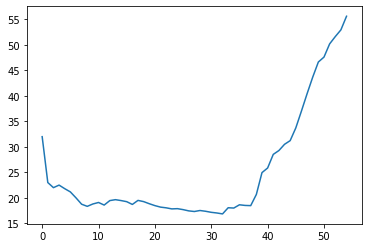

In [33]:
import pandas as pd
pd.Series(highscores).rolling(window=100, min_periods=1).mean().plot()

In [ ]:
test_highscores = []

for i in range(1):
    done = False
    score = 0
    observation = env.reset()
    
    while not done:
        env.render()
        action = agent.choose_action(observation)
        next_observation, reward, done, info = env.step(action)
        observation = next_observation
        score += reward
        
    test_highscores.append(score)
    
env.close()
test_highscores